<div style="text-align: right"> York University - ML1030 - Julia Mitroi </div>

# Sentiment Analysis for Movie Reviews

## Normalization and Keras Sequential CNN+DNN

### Installing libraries and packages

In [1]:
import os
import numpy as np 
import pandas as pd 
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import TreebankWordTokenizer 
from nltk.stem import WordNetLemmatizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup

import re

import seaborn as sns

import random

import keras
from keras.utils import to_categorical
from keras.preprocessing import sequence
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.models import Sequential

from keras.models import Sequential, load_model, Model
from keras.layers import Dense, LSTM, Dropout , Embedding, Conv1D , MaxPooling1D , Input, Reshape , Masking , TimeDistributed
from keras.layers import Concatenate, BatchNormalization, Bidirectional, Activation, GlobalMaxPooling1D
from keras.preprocessing.sequence import TimeseriesGenerator, pad_sequences
from keras.callbacks import History, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.constraints import maxnorm
from keras.regularizers import l1_l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, precision_score, accuracy_score
from sklearn.metrics import recall_score , confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics

import matplotlib
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

/Applications/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train_reviews = pd.read_csv("train.tsv", sep="\t")

In [3]:
test_reviews = pd.read_csv("test.tsv", sep="\t")

### Data Cleaning

In [4]:
# Make reviews text lowercase
train_reviews['Phrase'] = train_reviews['Phrase'].str.lower()
test_reviews['Phrase'] = test_reviews['Phrase'].str.lower()

In [5]:
train_reviews['Phrase'].head()

0    a series of escapades demonstrating the adage ...
1    a series of escapades demonstrating the adage ...
2                                             a series
3                                                    a
4                                               series
Name: Phrase, dtype: object

In [6]:
# Leaving only letters from a-z and digits
train_reviews['Phrase'] = train_reviews['Phrase'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
test_reviews['Phrase'] = test_reviews['Phrase'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

In [7]:
# Removing HTML content
train_reviews['Phrase'] = [BeautifulSoup(text).get_text() for text in train_reviews['Phrase']]
test_reviews['Phrase'] = [BeautifulSoup(text).get_text() for text in test_reviews['Phrase']]

### Treebank Tokenization

In [8]:
# Using the Penn U.'s' Treebank Word Tokenizer from ftp://ftp.cis.upenn.edu/pub/treebank/public_html/tokenization.html
# Through tokenization, each sentence is converterd to a sequence of tokens. 

treebank_tokenizer = TreebankWordTokenizer()

def tokenize(t):
    return ' '.join(treebank_tokenizer.tokenize(t))

sentences = train_reviews.Phrase.apply(tokenize)

### Lemmatization

In [9]:
# NLTK's WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def lemmatize(l):
    return ' '.join([lemmatizer.lemmatize(s) for s in l.split(' ')])    
    
sentences = sentences.apply(lemmatize)

In [10]:
sentences.head()

0    a series of escapade demonstrating the adage t...
1    a series of escapade demonstrating the adage t...
2                                             a series
3                                                    a
4                                               series
Name: Phrase, dtype: object

### Keras Pre-processing

In [11]:
# Preliminary to modeling, I will use Keras text preprocessing functions to further pre-process the sentences in the 
# train set, namely to transform the text into sequences of tokens, and pad those sequences to have the same length.

tokenizer = Tokenizer()
# fit_on_texts function creates vocabulary index based on word frequency in sentences
tokenizer.fit_on_texts(sentences)

# texts_to_sequences transforms each text in the sentences set to a sequence of integers
X = tokenizer.texts_to_sequences(sentences)

from keras.preprocessing.sequence import pad_sequences
# pad_sequences performs sequences padding
X = pad_sequences(X)

# Constructing the target
Y = pd.get_dummies(train_reviews.Sentiment).values

In [12]:
# Vocabulary Size.
vocab_size = len(tokenizer.word_index) + 1

print("Vocabulary size: ", vocab_size)
print("X's shape : " , X.shape)
print("Y's shape : " , X.shape)

Vocabulary size:  15023
X's shape :  (156060, 48)
Y's shape :  (156060, 48)


## Modeling

### CNN + Dense NN Architecture

In [32]:
# Model

def model(X , Y , embed_dim , vocab_size,
          lstm_layers = [] , lstm_dropout = [],
          cnn_layers = [] , cnn_kernels = [] , cnn_dropout = [], 
          max_pooling_layers = [] , max_pooling = False ,
          dense_layers = [] , dense_dropout = [] ,
          ntest_sers = 400 , epochs = 10 , batch_size = 32 , lr = 0.001 , decay = 0 , beta_1 = 0.9 , beta_2 = 0.999):
        
        
    # training and testing set :
    length  = X.shape[0] 
    target_shape = Y.shape[1]
    
    # Validation rate to pass to the Sequential Model :
    val_rate = ntest_sers/length
    
    
    # Model:
    
    history = History()
    checkpoint = ModelCheckpoint('model', save_best_only=True)
    
    model = Sequential()
    
    # Embedding layer
    model.add(Embedding(vocab_size, embed_dim, input_length = X.shape[1]))
    

    # Convolutional Network Layers
    for i in range(len(cnn_layers)):
        model.add(Conv1D(cnn_layers[i], cnn_kernels[i], padding = 'same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(cnn_dropout[i]))
        
        if max_pooling:
            model.add(MaxPooling1D(max_pooling_layers[i], stride = 1, padding = 'same'))
    
    if len(lstm_layers) == 0:
        
        #model.add(Reshape((-1,) ) ) # Reshaping
        #model.add( Reshape((lstm_layers[-1], X.shape[1]))  ) #for max pooling over time 
        model.add(GlobalMaxPooling1D())
    
    
    # Bi-LSTM Layers
    for i in range(len(lstm_layers)):
        
        rsequs  = not (i == (len(lstm_layers) - 1))
        model.add(Bidirectional( LSTM(lstm_layers[i] , return_sequences = rsequs)))
        
        if len(lstm_dropout)>0:
            model.add(Dropout(lstm_dropout[i]))
                      
    # Dense Layers        
    for i in range(len(dense_layers)):
         
        model.add(Dense(dense_layers[i] , activation = 'relu'))
        
        if len(dense_dropout)>0:
            model.add(Dropout(dense_dropout[i]))  
        
    model.add(Dense(target_shape , activation = 'softmax'))
    
    Nadam = keras.optimizers.Nadam(lr = lr , beta_1=0.9, beta_2=0.999, epsilon=1e-08)#, schedule_decay=0.0004)
    model.compile(loss='categorical_crossentropy', optimizer= Nadam , metrics = ['accuracy'])

    # Using early stoping to avoid overfitting
    early_stop = EarlyStopping(min_delta = 0.001, mode = 'max', monitor = 'val_acc', patience = 2)
    
    # Reduce learning rate when validation loss has stopped decreasing over 2 epochs
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=0, verbose=1, mode='auto', cooldown=0, min_lr=1e-6)
    
    
    # Fitting the data
    model.fit(X, Y, epochs= epochs, batch_size=batch_size, validation_split = val_rate,
              callbacks = [history, checkpoint, early_stop, reduce_lr])
    
    
    # Loading best_model
    model = load_model('model')

              
    # Loading best_model
    return model , min(history.history['val_loss'])

In [33]:
val = 1000

result = model(X, Y, embed_dim = 256, vocab_size = vocab_size,
               cnn_layers = [80] , cnn_kernels = [3] , cnn_dropout = [.3],
               max_pooling = True , max_pooling_layers = [3],
               dense_layers = [64] , dense_dropout = [.2],
               batch_size = 256, epochs = 20 , ntest_sers = val , lr = 0.001)

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(3, padding="same", strides=1)`


Train on 155060 samples, validate on 1000 samples
Epoch 1/20
155060/155060 [==============================] - 423s 3ms/step - loss: 1.0133 - acc: 0.5913 - val_loss: 0.9832 - val_acc: 0.6080
Epoch 2/20
155060/155060 [==============================] - 438s 3ms/step - loss: 0.8012 - acc: 0.6657 - val_loss: 0.9524 - val_acc: 0.6330
Epoch 3/20
155060/155060 [==============================] - 426s 3ms/step - loss: 0.7312 - acc: 0.6905 - val_loss: 0.9735 - val_acc: 0.6140

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
Epoch 4/20
155060/155060 [==============================] - 435s 3ms/step - loss: 0.6729 - acc: 0.7124 - val_loss: 0.9846 - val_acc: 0.6120

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0006400000303983689.


Validation accuracy = 63.3%

### Model Performance

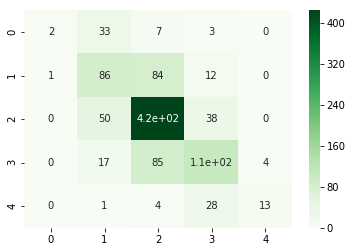

accuracy: 0.633
precision: [0.66666667 0.45989305 0.70247934 0.56914894 0.76470588]
recall: [0.04444444 0.46994536 0.82846004 0.50234742 0.2826087 ]


In [35]:
# Prediction
y_score = result[0].predict(X[-val:])
y_pred = np.argmax(y_score , axis = 1)

# True values
y_test = train_reviews.Sentiment.values[-val:]

# Confusion matrix
hmap = confusion_matrix(y_test , y_pred)
sns.heatmap(hmap , cmap = 'Greens' , annot = True)
plt.show()

# Metrics :
print('accuracy:', accuracy_score(y_test , y_pred))
print('precision:', precision_score(y_test , y_pred , average = None))
print('recall:', recall_score(y_test , y_pred , average = None))

class no: 0


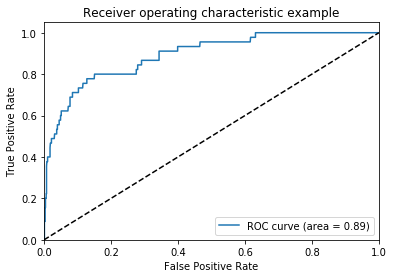

class no: 1


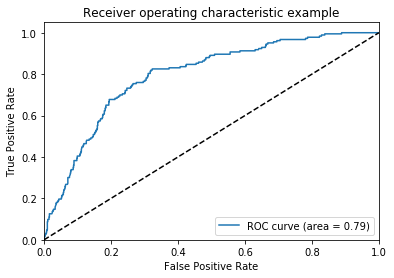

class no: 2


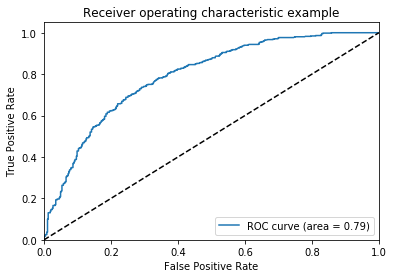

class no: 3


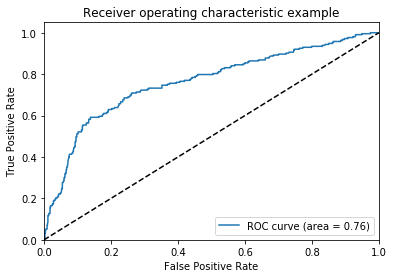

class no: 4


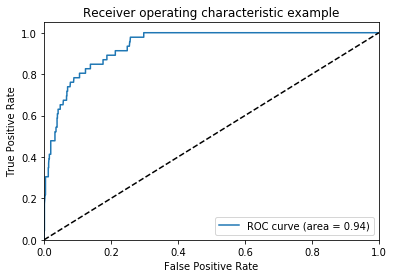

In [36]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 5

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_score[:, i] , pos_label = i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for each class (Sentiment label)
for i in range(n_classes):
    print('class no:', i )
    
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

Using area under ROC curve (AUC) as a measure of quality of the classification model: <br>
AUC for Sentiment 0 = 89% <br>
AUC for Sentiment 1 = 79% <br>
AUC for Sentiment 2 = 79% <br>
AUC for Sentiment 3 = 76% <br>
AUC for Sentiment 4 = 94% <br>

A high AUC, close to 1, means that the model has high classification accuracy.  Best quality of classification for Sentiments based on applying the CNN-DNN model above was for Sentiments 0 ("negative") and 4 ("positive"), with AUC scores of 89% and 94%, however the model performance was lower (<80%) on the somewhat positive, somewhat negative, and neutral reviews. Those reviews in the latter 3 classes contain both positive and negative words at the same time, which may confound the network. 
